## Quasi-Lagrangian view of a mesoscale oceanic eddy
**10 March 2022 by MiniUFO and Wei Wu**

---
[TOC]

---
### 1. Introduction
[Mesoscale oceanic eddies](https://en.wikipedia.org/wiki/Eddy_(fluid_dynamics)) are ubiquitous phenomenon in the ocean.  They are dynamically similar to the storms in the atmosphere, except that the rotating flow is quite slow (a few or tens of centimeters per second). A classic Eulerian view from satellite data is shown as the following figure.  Similar to a storm (or [tropical cyclone](./1.TCExample.ipynb)), it is best described in a cylindrical coordinates translating with the system.  That is the quasi-Lagrangian view.  Here we will use [`xvortices`](https://github.com/miniufo/xvortices) package to give a quick tutorial on how to take such quasi-Lagrangian view of a mesoscale oceanic eddy.

![eddy plot](../pics/oceanic_eddies.jpg)

---
### 2. Methods
#### 2.1 Load lat/lon data
First, we use the [mesoscale eddy dataset](https://ceoas.oregonstate.edu/mesoscale-eddies) to track a single eddy.  Then we use satellite product ([AVISO](https://climatedataguide.ucar.edu/climate-data/aviso-satellite-derived-sea-surface-height-above-geoid)) to get the flow and sea surface height (SSH) data on a regular lat/lon grid for interpolation.  The eddy information (an eddy over the southern Indian Ocean) has been converted into a txt file (`D:/NIO2013.txt`).

In [29]:
# loading data
import xarray as xr
import pandas as pd
import sys
sys.path.append('../../')

# load eddy data using pandas
eddy = pd.read_csv('D:/NIO2013.txt', sep='\s+', index_col='time', parse_dates=True)

# load gridded SSH and flow data
dset = xr.open_dataset('D:/dataset-duacs-nrt-global-merged-allsat-phy-l4_NIO_Eddy_2013.nc')

print(eddy[:10])
print('---------------------------------\n')
print(dset)

            h    lats     lons     amp     rad
time                                          
2013-05-20  0  5.0935  93.5035  1.5232  102754
2013-05-21  0  4.7296  93.1146  2.8712  167353
2013-05-22  0  4.5898  92.7821  5.4253  221682
2013-05-23  0  4.6468  92.5558  6.3175  229839
2013-05-24  0  4.7816  91.9965  7.0000  213747
2013-05-25  0  4.9227  91.4880  7.7744  269162
2013-05-26  0  4.9410  90.9292  7.5110  256549
2013-05-27  0  4.9344  90.2025  8.3398  153525
2013-05-28  0  4.9006  89.4764  8.9553  151917
2013-05-29  0  4.8667  88.7270  8.8919  262230
---------------------------------

<xarray.Dataset>
Dimensions:    (time: 56, latitude: 60, longitude: 121)
Coordinates:
  * latitude   (latitude) float32 -4.875 -4.625 -4.375 ... 9.375 9.625 9.875
  * time       (time) datetime64[ns] 2013-05-20 2013-05-21 ... 2013-07-14
  * longitude  (longitude) float32 69.88 70.12 70.38 70.62 ... 99.38 99.62 99.88
Data variables:
    adt        (time, latitude, longitude) float64 ...
    ugos    

#### 2.2 Interpolation onto cylindrical coordinate
Notice that the time range of `dset` is the same as the `eddy`.  This is generally not necessary as [`xarray`](http://xarray.pydata.org/) will take a broadcast along the time dimension.  Now we use [`xvortices`](https://github.com/miniufo/xvortices) to interpolate lat/lon data onto cylindrical coordinate.

In [4]:
from xvortices.xvortices import load_cylind

olon = eddy.lons.to_xarray() # convert DataFrame to xarray
olat = eddy.lats.to_xarray() # convert DataFrame to xarray

[sla, adt, ugos, vgos], lons, lats, etas = load_cylind(dset[['sla','adt','ugos','vgos']],
                                             olon=olon, olat=olat, # center positions of eddy
                                             azimNum=72,           # 72 points azimuthally
                                             radiNum=31,           # 31 points radially
                                             radMax=4,             # max radius of 4 degree (444km)
                                             lonname='longitude',  # lat/lon names in gridded dataset
                                             latname='latitude')

Now we are able to plot the interpolated fields $sla$ in a cylindrical grid.  Notice that the eddy is near the equatorial region, so the Mercator projection is much preferred.

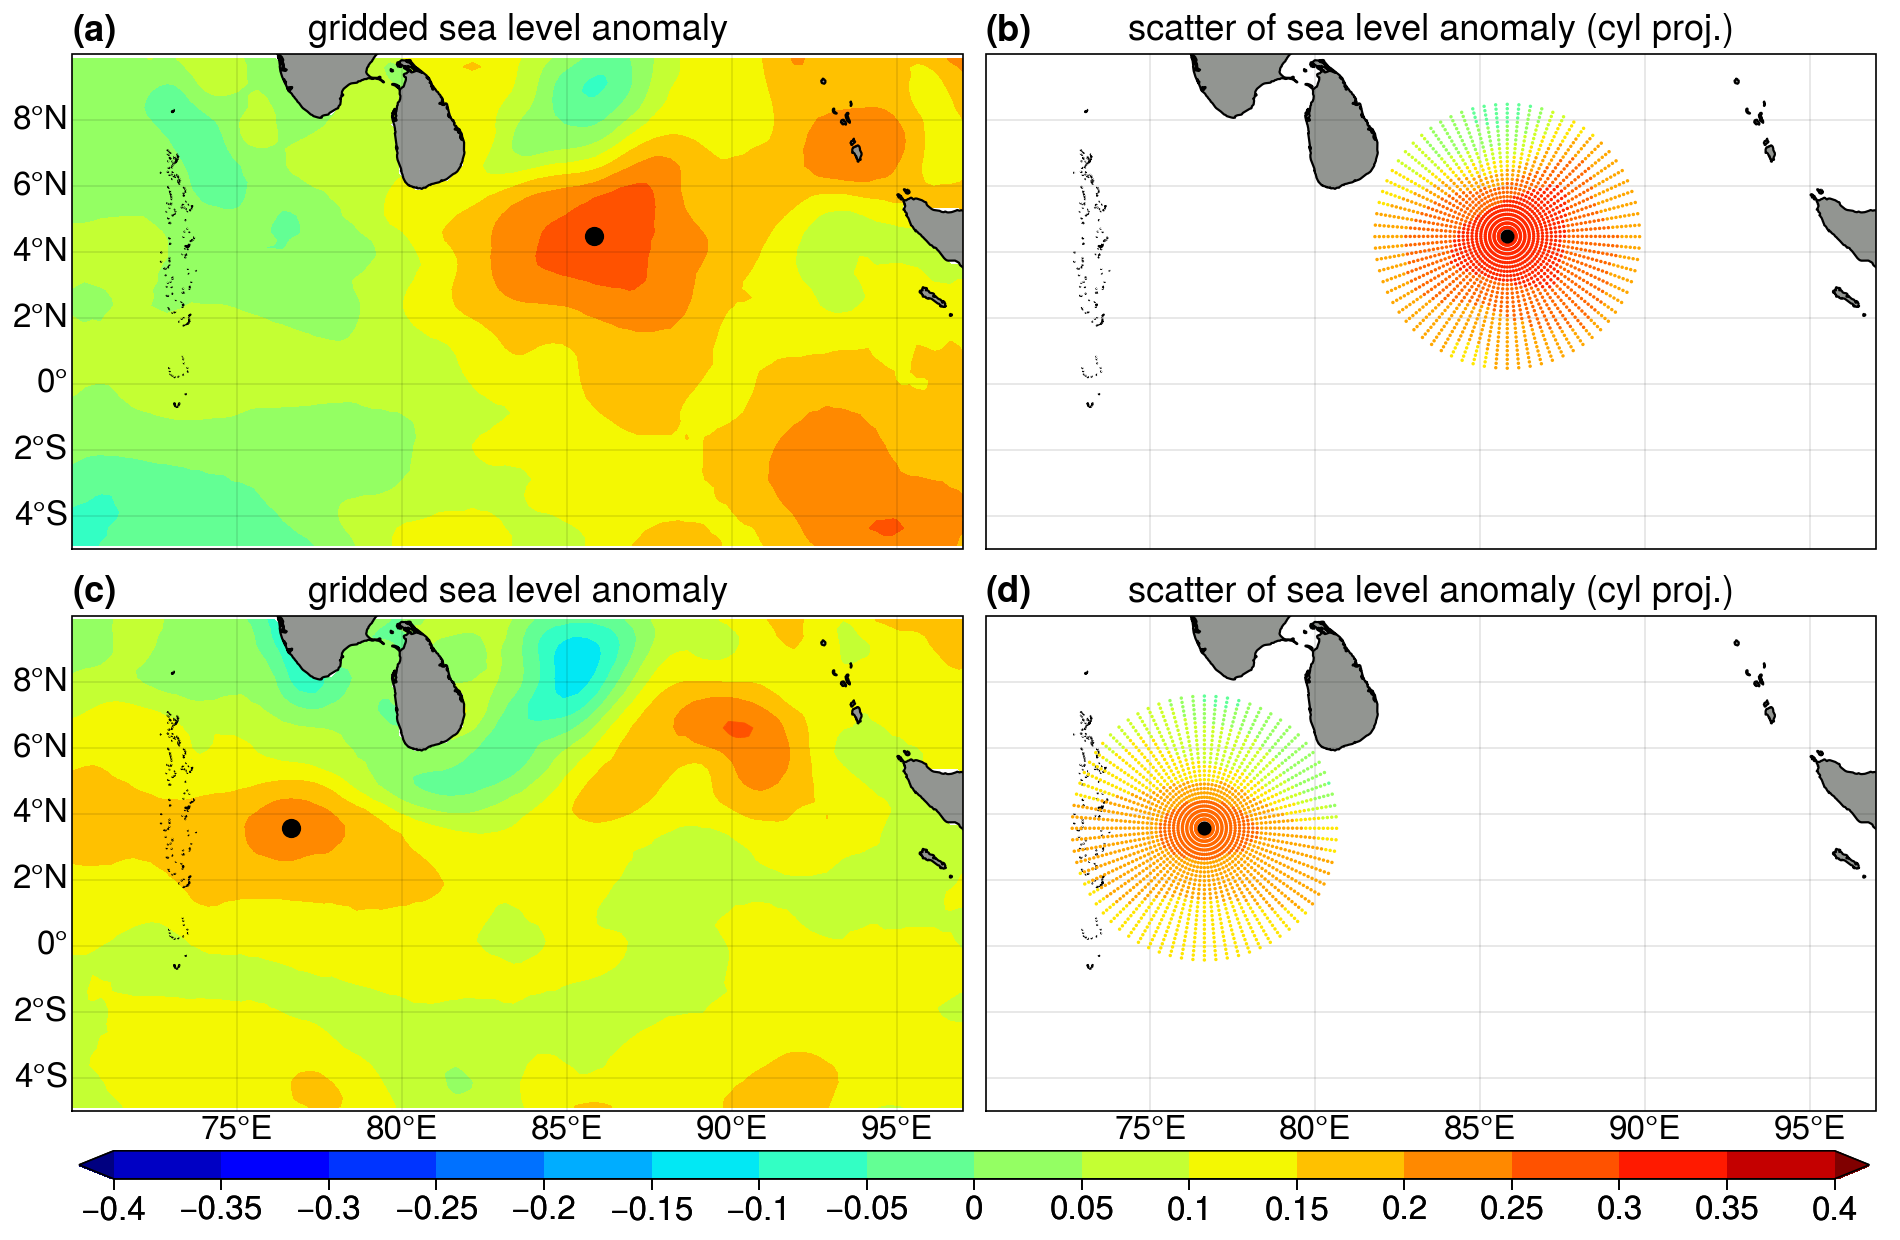

In [10]:
# plot horizontal interpolation
import proplot as pplt
import numpy as np
%matplotlib inline

pplt.rc.reso = 'hi'
fontsize = 13

fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(9.5,6.2), sharex=3, sharey=3,
                          proj=[pplt.Proj('cyl', lon_0=180), pplt.Proj('cyl', lon_0=180),
                                pplt.Proj('cyl', lon_0=180), pplt.Proj('cyl', lon_0=180)])
tlev = 20
ax = axes[0,0]
m=ax.contourf(dset.sla[tlev], cmap='jet', levels=np.linspace(-0.4, 0.4, 17), extend='both')
ax.scatter(olon[tlev], olat[tlev], s=40, c='k')
ax.set_title('gridded sea level anomaly', fontsize=fontsize)
ax.format(lonlabels=False, latlabels='l')

ax = axes[0,1]
ax.scatter(lons[tlev].data.flatten(), lats[tlev].data.flatten(), s=0.4, c=sla[tlev].data.ravel(),
           cmap='jet', zorder=2, levels=np.linspace(-0.4, 0.4, 17))
ax.scatter(olon[tlev], olat[tlev], s=20, c='k', zorder=3)
ax.set_title('scatter of sea level anomaly (cyl proj.)', fontsize=fontsize)
ax.format(labels=False)

tlev = 40
ax = axes[1,0]
m=ax.contourf(dset.sla[tlev], cmap='jet', levels=np.linspace(-0.4, 0.4, 17), extend='both')
ax.scatter(olon[tlev], olat[tlev], s=40, c='k')
ax.set_title('gridded sea level anomaly', fontsize=fontsize)
ax.format(lonlabels='b', latlabels='l')

ax = axes[1,1]
ax.scatter(lons[tlev].data.flatten(), lats[tlev].data.flatten(), s=0.4, c=sla[tlev].data.ravel(),
           cmap='jet', zorder=2, levels=np.linspace(-0.4, 0.4, 17))
ax.scatter(olon[tlev], olat[tlev], s=20, c='k', zorder=3)
ax.set_title('scatter of sea level anomaly (cyl proj.)', fontsize=fontsize)
ax.format(lonlabels='b', latlabels=False)

fig.colorbar(m, loc='b', length=0.98, cols=(1,2), ticks=0.05, width=0.14, pad=0.0, title='')

axes.format(abc='(a)', land=True, landcolor='gray', borders=True, coast=True, lonlines=5, latlines=2,
            coastcolor='k', latlim=[-5, 10], lonlim=[70, 97])

#### 2.3 Quasi-Lagrangian view and vector re-projection
Now, we will subtract the translating velocity of the eddym from the velocity components, and obtain the eddy-relative velocity.  This is a quasi-Lagrangian view of the current vector.

In [11]:
from xvortices.xvortices import project_to_cylind, storm_relative

# finite difference along time to get the translating velocity of the eddy
uo = (eddy['lons'].diff()/86400).to_xarray()*np.cos(np.deg2rad(eddy['lats']))
vo = (eddy['lats'].diff()/86400).to_xarray()

# eddy-relative current components
u_r = ugos - uo
v_r = vgos - vo

# reproject the current vector into azimuthal and radial components
uaz_r, vra_r = project_to_cylind(u_r, v_r, etas)

Now we are able to plot the storm-relative azimuthal/radial currents.

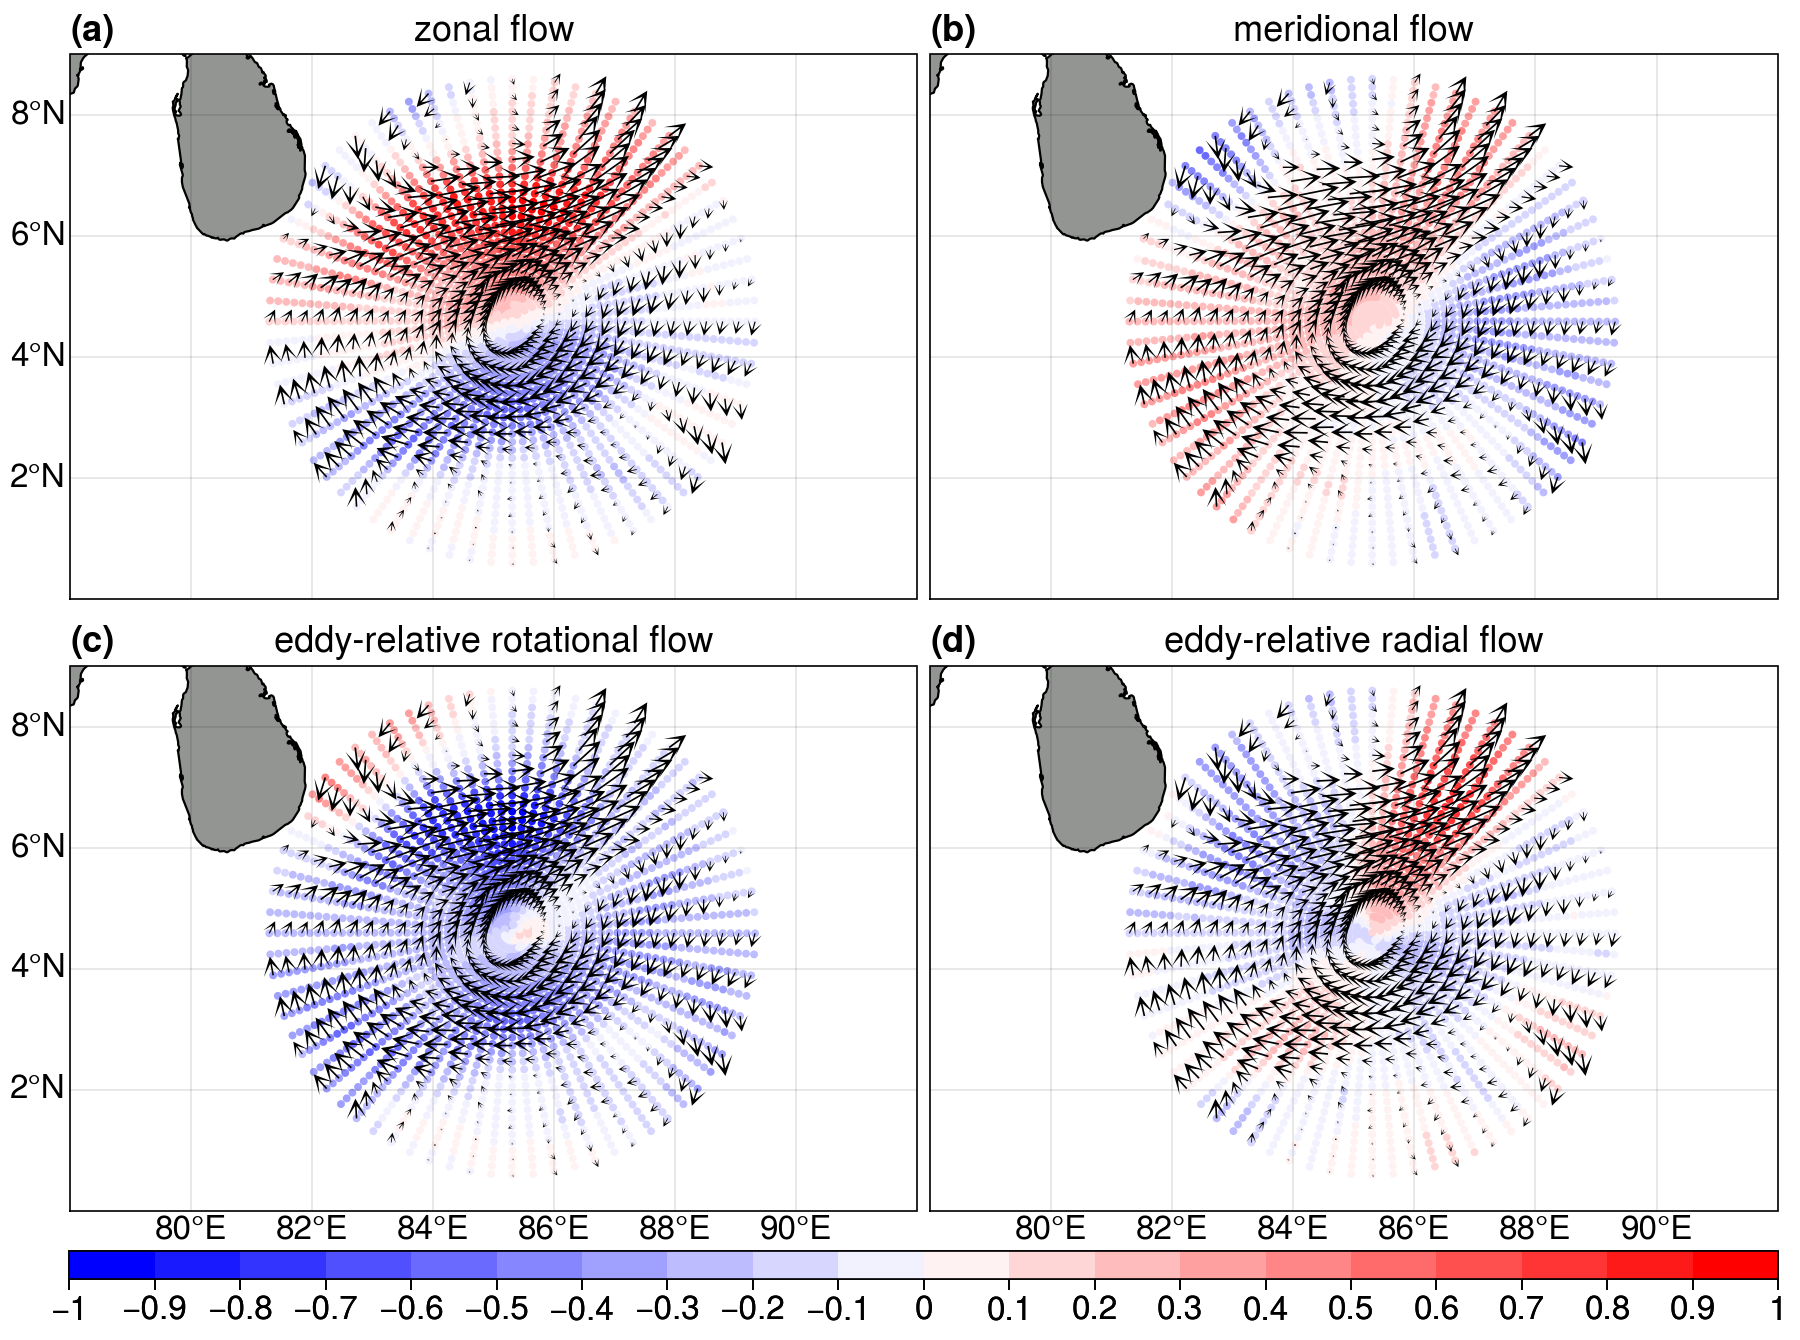

In [18]:
# plot flow components
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(9, 6.7), sharex=3, sharey=3,
                          proj=[pplt.Proj('cyl', lon_0=180), pplt.Proj('cyl', lon_0=180),
                                pplt.Proj('cyl', lon_0=180), pplt.Proj('cyl', lon_0=180)])
tlev = 22
ax = axes[0,0]
ax.scatter(lons[tlev].data.flatten(), lats[tlev].data.flatten(), s=5, c=ugos[tlev].data.ravel(),
           cmap='bwr', levels=np.linspace(-1, 1, 21))
ax.quiver(lons[tlev].data[4::2,::2].flatten(), lats[tlev].data[4::2,::2].flatten(),
          ugos[tlev].data[4::2,::2].ravel(), vgos[tlev].data[4::2,::2].ravel(),
          width=0.002, headwidth=12., headlength=12., scale=16, zorder=2)
ax.set_title('zonal flow', fontsize=fontsize)
ax.format(lonlabels=False, latlabels='l')

ax = axes[0,1]
ax.scatter(lons[tlev].data.flatten(), lats[tlev].data.flatten(), s=5, c=vgos[tlev].data.ravel(),
           cmap='bwr', levels=np.linspace(-1, 1, 21))
ax.quiver(lons[tlev].data[4::2,::2].flatten(), lats[tlev].data[4::2,::2].flatten(),
          ugos[tlev].data[4::2,::2].ravel(), vgos[tlev].data[4::2,::2].ravel(),
          width=0.002, headwidth=12., headlength=12., scale=16, zorder=2)
ax.set_title('meridional flow', fontsize=fontsize)
ax.format(labels=False)

ax = axes[1,0]
ax.scatter(lons[tlev].data.flatten(), lats[tlev].data.flatten(), s=5, c=uaz_r[tlev].data.ravel(),
           cmap='bwr', levels=np.linspace(-1, 1, 21))
ax.quiver(lons[tlev].data[4::2,::2].flatten(), lats[tlev].data[4::2,::2].flatten(),
          ugos[tlev].data[4::2,::2].ravel(), vgos[tlev].data[4::2,::2].ravel(),
          width=0.002, headwidth=12., headlength=12., scale=16, zorder=2)
ax.set_title('eddy-relative rotational flow', fontsize=fontsize)
ax.format(lonlabels='b', latlabels='l')

ax = axes[1,1]
m=ax.scatter(lons[tlev].data.flatten(), lats[tlev].data.flatten(), s=5, c=vra_r[tlev].data.ravel(),
           cmap='bwr', levels=np.linspace(-1, 1, 21))
ax.quiver(lons[tlev].data[4::2,::2].flatten(), lats[tlev].data[4::2,::2].flatten(),
          ugos[tlev].data[4::2,::2].ravel(), vgos[tlev].data[4::2,::2].ravel(),
          width=0.002, headwidth=12., headlength=12., scale=16, zorder=2)
ax.set_title('eddy-relative radial flow', fontsize=fontsize)
ax.format(lonlabels='b', latlabels=False)

fig.colorbar(m, loc='b', length=1, cols=(1,2), ticks=0.1, width=0.14, pad=0.0, title='')

axes.format(abc='(a)', land=True, landcolor='gray', borders=True, coast=True, lonlines=2, latlines=2,
            coastcolor='k', latlim=[0, 9], lonlim=[78, 92])

#### 2.4 Structural evolution of the eddy
Now it is able to plot the structural evolution of the eddy.  The structure is defined as the azimuthal mean and we can plot the radial-depth structure of the eddy.  However, since there is only surface data, we can plot the evolution of the rotational flow, which characterizes the changes of the eddy intensity/strength.

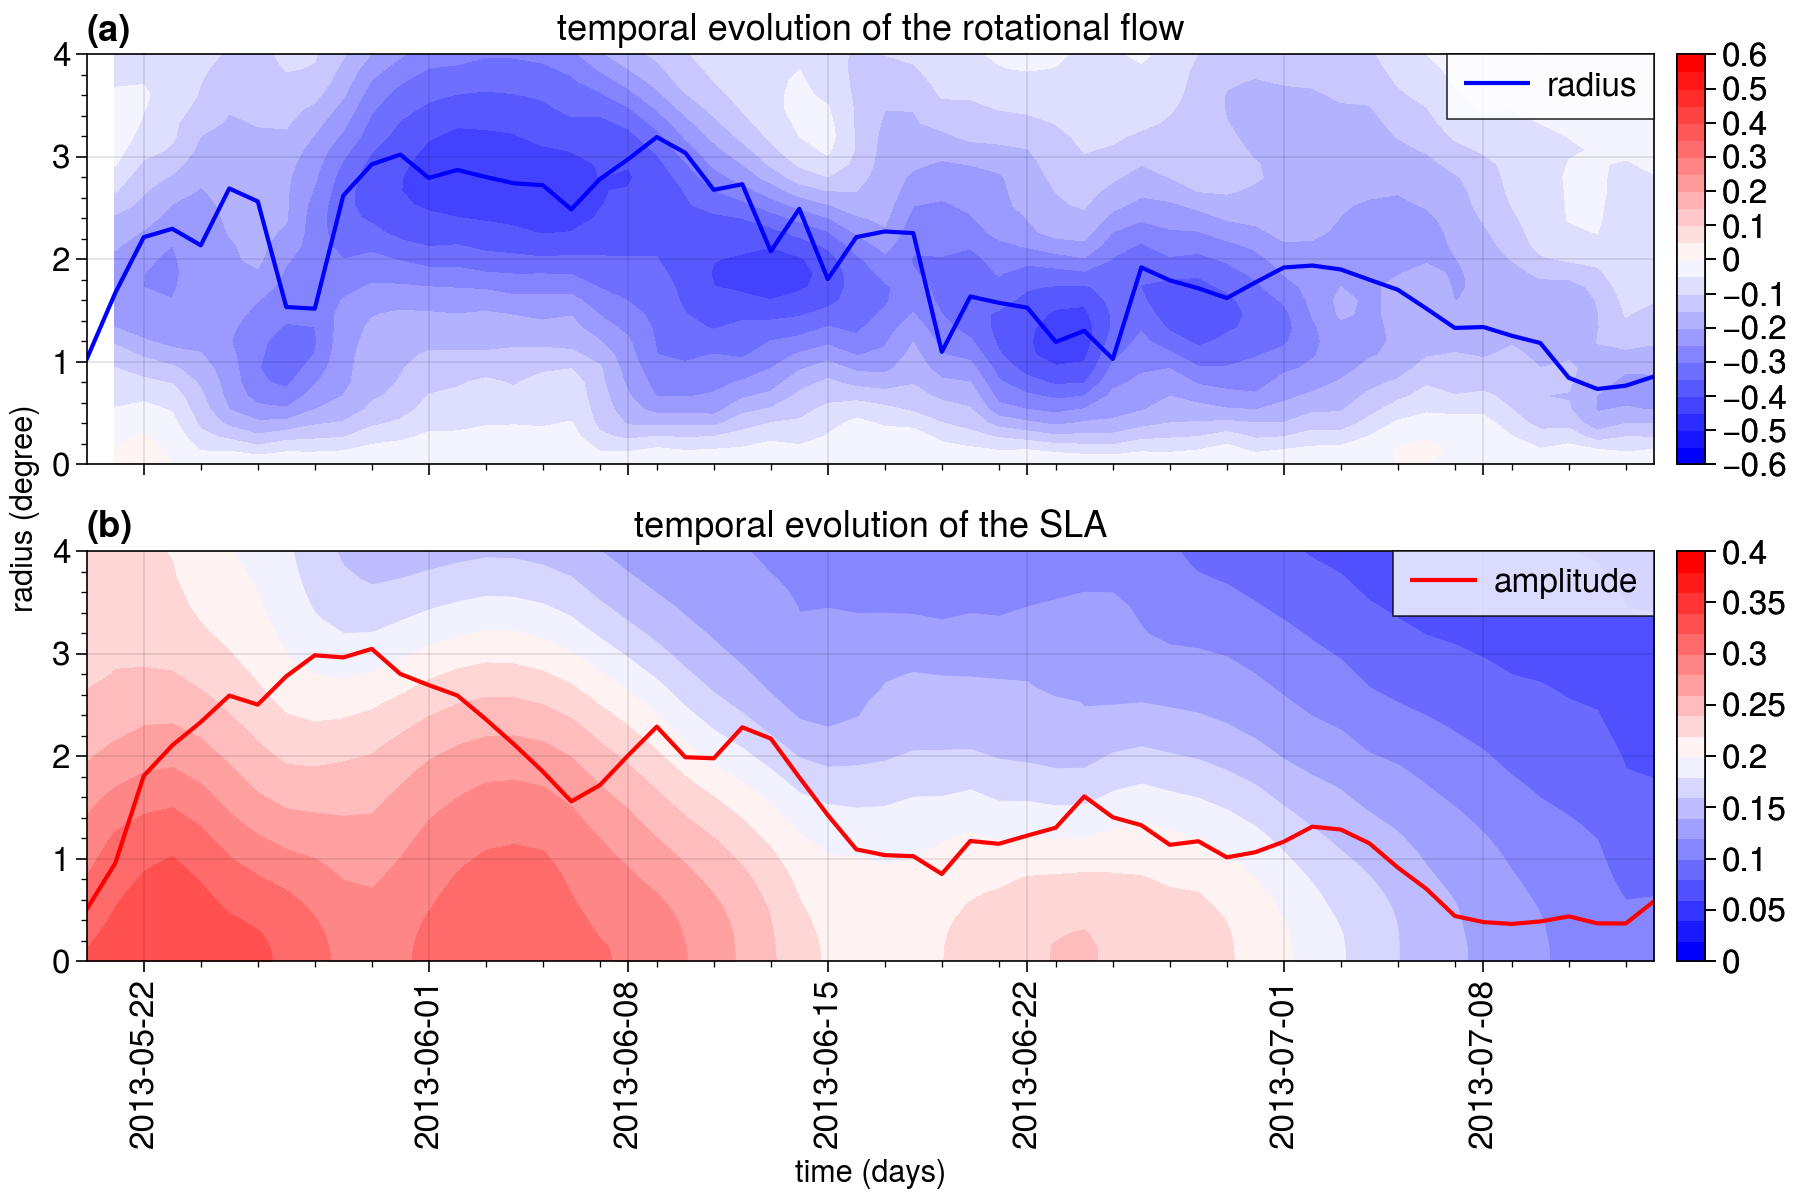

In [35]:
# azimuthal mean
uaz_rm = uaz_r.mean('azim')
sla_rm = sla.mean('azim')

fig, axes = pplt.subplots(nrows=2, ncols=1, figsize=(9, 6))
ax = axes[0]
m=ax.contourf(uaz_rm.T, cmap='bwr', levels=np.linspace(-0.6, 0.6, 25))
l2=ax.plot(eddy.index, eddy.rad/1e5, c='b', label='radius')
ax.set_title('temporal evolution of the rotational flow', fontsize=fontsize)
ax.legend(l2, loc='ur')
ax.set_xlabel('time (days)', fontsize=fontsize-2)
ax.set_ylabel('radius (degree)', fontsize=fontsize-2)
ax.colorbar(m, loc='r', length=1, ticks=0.1, width=0.14, pad=0.0, title='')

ax = axes[1]
m=ax.contourf(sla_rm.T, cmap='bwr', levels=np.linspace(0, 0.4, 21))
l1=ax.plot(eddy.index, eddy.amp/3, c='r', label='amplitude')
ax.set_title('temporal evolution of the SLA', fontsize=fontsize)
ax.legend(l1, loc='ur')
ax.set_xlabel('time (days)', fontsize=fontsize-2)
ax.set_ylabel('radius (degree)', fontsize=fontsize-2)
ax.colorbar(m, loc='r', length=1, ticks=0.05, width=0.14, pad=0.9, title='')

axes.format(abc='(a)')

---
### References
1. ...